## Part 1/3: Prepare Hardware and Data

In [1]:
#import tensorflow and other libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
img_folder = "msl-images-oversample"

2023-08-19 07:20:12.559800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 07:20:13.037530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Tensorflow GPU memory allocation fix
#https://github.com/tensorflow/tensorflow/issues/35264
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-08-19 07:20:15.600672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-19 07:20:15.605441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-19 07:20:15.605592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Input pipeline
Using the Keras ImageDataGenerator, the dataset is split into train and validation in an 80/20 split. Class weights are calulated after loading the dataset.

Found 9842 images belonging to 5 classes.
Found 2458 images belonging to 5 classes.

{0: 0.9725296442687748, 1: 0.9163873370577281, 2: 0.9472569778633301, 3: 0.9866666666666667, 4: 1.2325610519724484}


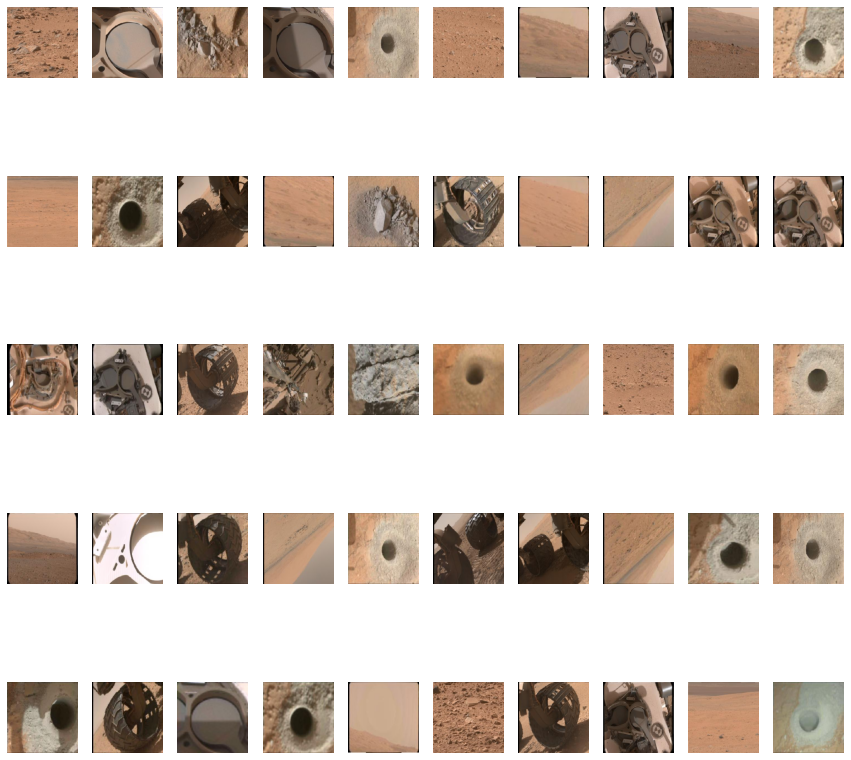

In [3]:
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Set the image size and batch size
img_height = 227
img_width = 227
batch_size = 32

# Create ImageDataGenerator for data augmentation and loading the dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, # Normalize pixel values to [0, 1]
    validation_split=0.2 # set validation split
    # Add other data augmentation parameters as needed
)

# Load the dataset using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    img_folder,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,       # Important: Shuffle the data to avoid issues with class weighting
    seed=123,            # Set seed for reproducibility
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    img_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,       # Important: Shuffle the data to avoid issues with class weighting
    seed=123,            # Set seed for reproducibility
    subset='validation')

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)


# Convert class weights to a dictionary format
class_weights_dict = dict(enumerate(class_weights))
print("")
print(class_weights_dict)

#show some images
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(15,15))

for i in range(5):
    for j in range(10):

        # convert to unsigned integers for plotting
        image = next(train_generator)[0][0]

        # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
        image = np.squeeze(image)

        # plot raw pixel data
        ax[i][j].imshow(image)
        ax[i][j].axis('off')

## Here, the dataset's class distribution is shown to verify the split

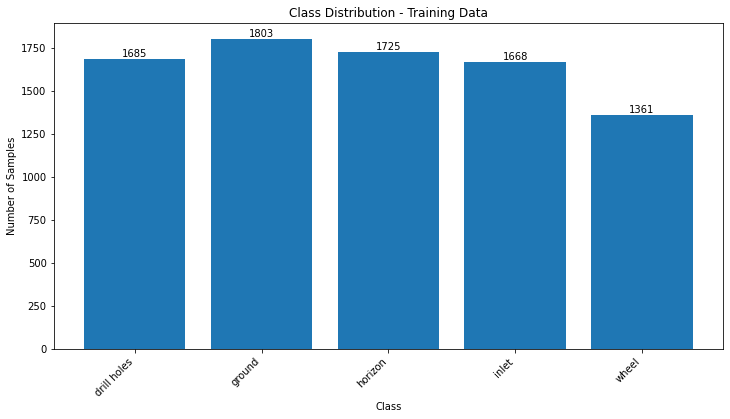

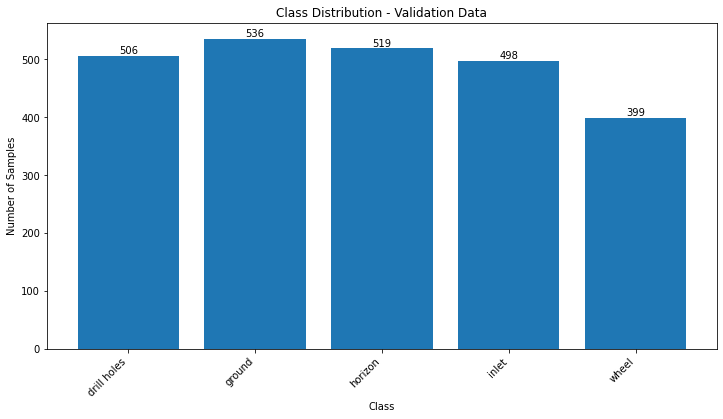

In [4]:
import matplotlib.pyplot as plt

# Get the number of classes
num_classes = len(train_generator.class_indices)

# Count the number of samples for each class in the training data
train_class_counts = np.zeros(num_classes)
for _, labels in train_generator:
    for label in labels.argmax(axis=1):
        train_class_counts[label] += 1
    if train_generator.batch_index == 0:
        break

# Count the number of samples for each class in the validation data
validation_class_counts = np.zeros(num_classes)
for _, labels in validation_generator:
    for label in labels.argmax(axis=1):
        validation_class_counts[label] += 1
    if validation_generator.batch_index == 0:
        break

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Plot the class distribution for training data
plt.figure(figsize=(12, 6))
plt.bar(class_labels, train_class_counts)
plt.title("Class Distribution - Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')

# Add number labels to each bar
for i, count in enumerate(train_class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

# Plot the class distribution for validation data
plt.figure(figsize=(12, 6))
plt.bar(class_labels, validation_class_counts)
plt.title("Class Distribution - Validation Data")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')

# Add number labels to each bar
for i, count in enumerate(validation_class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

## Part 2/3: Building and Training

In [5]:
#alexnet
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_height, img_width,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax')
])

2023-08-19 07:20:38.956011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-19 07:20:38.956183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-19 07:20:38.956280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
#see the layers!
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [8]:
#set training parameters
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

In [9]:
#train the model, time to cook!


#set up tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

epochs=20

history = model.fit(
    train_generator,
    epochs = epochs,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    callbacks = [tensorboard_callback]
    #class_weight = class_weights_dict
)

Epoch 1/20


/home/riley/.local/lib/python3.10/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-08-19 07:20:50.446604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-08-19 07:20:50.745502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-19 07:20:50.748491: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6147c7fcb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-19 07:20:50.748524: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-08-19 07:20:50.751328: I tensorflow

307/307 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.9301

2023-08-19 07:21:08.337224: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9059696640 exceeds 10% of free system memory.
2023-08-19 07:21:11.504446: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4026531840 exceeds 10% of free system memory.


307/307 [==============================] - 23s 62ms/step - loss: 0.4066 - accuracy: 0.9301 - val_loss: 7.2543 - val_accuracy: 0.2237
Epoch 2/20
307/307 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9701

2023-08-19 07:21:26.604806: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9059696640 exceeds 10% of free system memory.
2023-08-19 07:21:28.924668: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4026531840 exceeds 10% of free system memory.


307/307 [==============================] - 17s 56ms/step - loss: 0.1992 - accuracy: 0.9701 - val_loss: 1.1957 - val_accuracy: 0.8668
Epoch 3/20
307/307 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9764

2023-08-19 07:21:43.757260: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9059696640 exceeds 10% of free system memory.


307/307 [==============================] - 17s 56ms/step - loss: 0.1609 - accuracy: 0.9764 - val_loss: 4.4459 - val_accuracy: 0.6904
Epoch 4/20
307/307 [==============================] - 21s 68ms/step - loss: 0.0902 - accuracy: 0.9854 - val_loss: 3.4389 - val_accuracy: 0.7118
Epoch 5/20
307/307 [==============================] - 18s 58ms/step - loss: 0.0505 - accuracy: 0.9922 - val_loss: 5.2100 - val_accuracy: 0.7484
Epoch 6/20
307/307 [==============================] - 19s 63ms/step - loss: 0.0950 - accuracy: 0.9869 - val_loss: 9.2628 - val_accuracy: 0.6538
Epoch 7/20
307/307 [==============================] - 18s 59ms/step - loss: 0.1128 - accuracy: 0.9862 - val_loss: 4.0287 - val_accuracy: 0.7208
Epoch 8/20
307/307 [==============================] - 22s 73ms/step - loss: 0.0832 - accuracy: 0.9904 - val_loss: 7.7397 - val_accuracy: 0.5440
Epoch 9/20
307/307 [==============================] - 18s 58ms/step - loss: 0.1416 - accuracy: 0.9855 - val_loss: 2.2329 - val_accuracy: 0.8943
Epo

# 

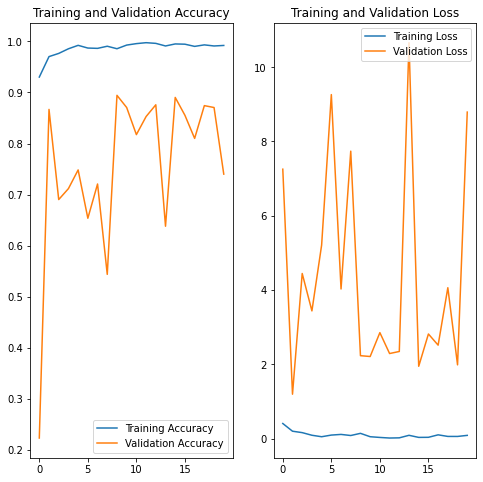

In [10]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Part 3/3: Evaluation and Predictions

In [11]:
#evaluate the accuracy
score = model.evaluate(validation_generator, verbose=0)
print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))

Validation Loss: 8.803455352783203
Validation Accuracy: 0.7400325536727905
